### **Initialization**

*Setting up for Fast.ai Environment*

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


**Downloading the Dependencies**

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *

**Preparing the Data.**

*Downloading the Data.*

In [4]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [5]:
df = pd.read_csv(path/"texts.csv")
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [6]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

*Fast.ai has TextDataBunch which performs Tokenizationa and Numericalization itself and makes the Data ready to use.*

In [7]:
data_lm = TextDataBunch.from_csv(path, "texts.csv")

In [8]:
data_lm.save()

*Loading the Data*

In [9]:
data = load_data(path)

**Tokenization**

In [10]:
data = TextClasDataBunch.from_csv(path, "texts.csv")
data.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


**Numericalization**

In [11]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [12]:
data.train_ds[0][0]

Text [  2  19 341   9 ...  60  14 170  11]

**Data Block API**

In [13]:
data = (TextList.from_csv(path, "texts.csv", cols="text")
        .split_from_df(col=2)
        .label_from_df(cols=0)
        .databunch())

## **Language Model**

In [14]:
# BatchSize
bs = 48

In [15]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas')]

In [16]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]

In [17]:
data_lm = (TextList.from_folder(path)
          # Inputs: All text files
          .filter_by_folder(include=['train', 'test', 'unsup'])
          .split_by_rand_pct(0.1)
          .label_for_lm()
          .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [18]:
data_lm = load_data(path, "data_lm.pkl", bs=bs)

In [19]:
data_lm.show_batch()

idx,text
0,"i wanted to see more of xxmaj bashki 's films . i saw xxmaj cool xxmaj world and thought it was mediocre and i saw this . xxmaj when it was first released , the film was very controversial . xxmaj it was considered racist and xxmaj al xxmaj sharpton wanted the film banned , he even led protests outside the theatre where the film was playing . xxmaj the"
1,"kundry 's famous line , "" i saw him ... him ... and laughed . "" xxmaj this gets translated , in the subtitles , for reasons which escape me , as "" i saw the xxmaj savior 's face . "" xxmaj it is especially irritating to me , because throughout the libretto , xxmaj wagner very deliberately and carefully refers to this unseen character xxup who xxup need"
2,special effects needed to really capture the essence of the ship actually sinking . xxmaj this film is so accurate that even xxmaj james xxmaj cameron timed the actual sinking of the ship in the film with the xxup real sinking that fateful day in xxmaj april 1912 . xxmaj even the silverware for goodness sakes matched ! \n \n xxmaj give this movie a break you guys !
3,"xxup bc region where the movie was shot is breathtaking ) . xxmaj the life most of us dream of is dismantled by dreams , phantoms , and his own past , until the day a teenaged criminal breaks in ... and , trite as it sounds , breaks him out . \n \n xxmaj canadian cinema suffers from several problems . xxmaj generally , a lack of money"
4,"dreams were , it was beautiful . xxmaj joe xxmaj johnston should direct more of these brilliant , acting driven films as well as his xxmaj big budget blockbuster faire , which is also excellent . xxup kudos ! ! to all involved in this masterpiece ! xxbos xxmaj an excellent period murder melodrama , with xxmaj fontaine effectively playing against her earlier naive wallflower type , in a role"


In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


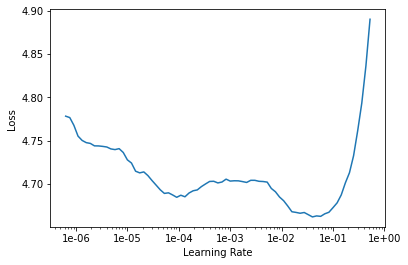

In [22]:
learn.recorder.plot(skip_end=15)

In [23]:
learn.fit_one_cycle(1, 1e-02, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.169403,4.021929,0.295520,1:28:21


In [24]:
learn.save('fit_head')

In [25]:
learn.load('fit_head');

**Training the Whole Model**

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(1, 1e-03, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.786507,3.734838,0.329110,1:37:57


In [28]:
learn.save("fine_tuned")

In [29]:
learn.load('fine_tuned');

In [31]:
TEXT = "I hate this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [32]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hate this movie because i think it 's another movie of the same kind . i 've seen Ren & Stimpy and Stopping In The World and you have to watch the movie twice half a night and
I hate this movie because it is so very bad . My husband and i were in bed . What we were thinking about was the first time i saw it . It called the " Snow White " .


In [33]:
learn.save_encoder("fine_tuned_enc")

## **Classifier**

In [35]:
path = untar_data(URLs.IMDB)

In [51]:
data_cls = (TextList.from_folder(path, vocab=data_lm.vocab)
            .split_by_folder(valid="test")
            .label_from_folder(classes=['neg', 'pos'])
            .databunch(bs=bs))

data_cls.save('data_cls.pkl')

In [52]:
data_cls = load_data(path, "data_cls.pkl", bs=bs)

In [38]:
data_cls.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj some have praised xxunk xxmaj lost xxmaj xxunk as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of",neg
"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxup xxunk "" and "" xxup beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this",neg
"xxbos xxmaj director xxmaj douglas xxmaj sirk once said ` there 's a very short distance between high art and trash , and trash that contains craziness is by this very quality nearer to art ' . xxmaj this statement defines his cinema perfectly , a very unique body of work that includes classic stage adaptations , adventure and war films , westerns and of course , his famous melodramas",pos
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n \n xxmaj so , i approached watching this the way i 'd approach doing homework . \n \n i",pos


In [53]:
learn = text_classifier_learner(data_cls, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxup mpaa : xxmaj rated r for xxmaj violence , xxmaj language , xxmaj nudity and xxmaj brief xxmaj drug xxmaj use . xxmaj quebec xxmaj rating:13 + xxmaj canadian xxmaj home xxmaj video xxunk 
 
  i saw xxmaj coonskin today . xxmaj this film is also known as xxmaj bustin xxmaj out and xxmaj street xxmaj fight . xxmaj after watching xxmaj fritz xxmaj the xxmaj cat , i wanted to see more of xxmaj bashki 's films . i saw xxmaj cool xxmaj world and thought it was mediocre and i saw this . xxmaj when it was first released , the film was very controversial . xxmaj it was considered racist and xxmaj al xxmaj sharpton wanted the film banned , he even led protests outside the theatre where the film was playing . xxmaj the film was only released on xxup vhs under the title " xxmaj street xxmaj xxunk . xxmaj it is now considered a cult - classic film and xxmaj african - xxmaj american celebrities such as comedian 

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


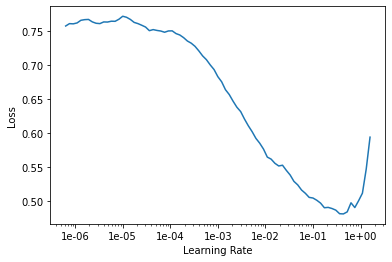

In [41]:
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(1, 1e-01, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.293647,0.225800,0.912160,10:11


In [43]:
learn.save('first')

In [44]:
learn.load('first');

In [45]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-02/(2.6**4), 1e-02), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.244664,0.185331,0.929720,11:11


In [46]:
learn.save('second')

In [47]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxup mpaa : xxmaj rated r for xxmaj violence , xxmaj language , xxmaj nudity and xxmaj brief xxmaj drug xxmaj use . xxmaj quebec xxmaj rating:13 + xxmaj canadian xxmaj home xxmaj video xxunk 
 
  i saw xxmaj coonskin today . xxmaj this film is also known as xxmaj bustin xxmaj out and xxmaj street xxmaj fight . xxmaj after watching xxmaj fritz xxmaj the xxmaj cat , i wanted to see more of xxmaj bashki 's films . i saw xxmaj cool xxmaj world and thought it was mediocre and i saw this . xxmaj when it was first released , the film was very controversial . xxmaj it was considered racist and xxmaj al xxmaj sharpton wanted the film banned , he even led protests outside the theatre where the film was playing . xxmaj the film was only released on xxup vhs under the title " xxmaj street xxmaj xxunk . xxmaj it is now considered a cult - classic film and xxmaj african - xxmaj american celebrities such as comedian 

In [48]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-02/(2.6**4), 1e-02), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.222333,0.165997,0.939720,19:50
1,0.139788,0.150020,0.944120,18:58
